<a href="https://colab.research.google.com/github/HamzaBTW/WeatherPredictor/blob/main/Weather_Predictor.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Weather Prediction**

<ipython-input-2-d0fa91c9ffc0>:11: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  core_weather = core_weather.fillna(method="ffill")


Mean Absolute Error: 3.2832393652840013


<Axes: xlabel='DATE'>

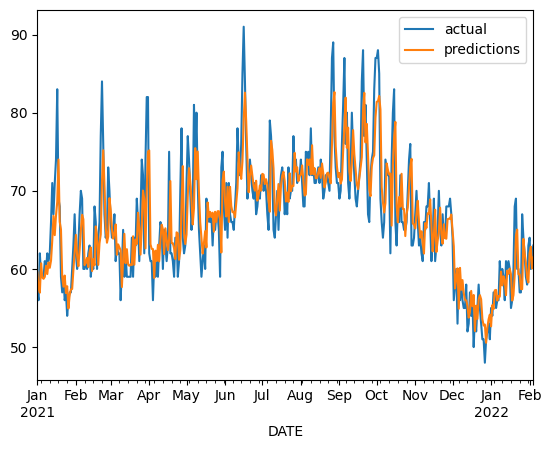

In [2]:
import pandas as pd
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_absolute_error

# Load and clean the weather data
weather = pd.read_csv("3776964.csv", index_col="DATE")
core_weather = weather[["PRCP", "TMAX", "TMIN"]].copy()

# Fill missing values
core_weather["PRCP"] = core_weather["PRCP"].fillna(0)
core_weather = core_weather.fillna(method="ffill")

# Convert index to datetime
core_weather.index = pd.to_datetime(core_weather.index)

# Create target column for prediction
core_weather["target"] = core_weather.shift(-1)["TMAX"]
core_weather = core_weather.iloc[:-1, :].copy()

# Define a function to create predictions
def create_predictions(predictors, core_weather, reg):
    train = core_weather.loc[:"2020-12-31"]
    test = core_weather.loc["2021-01-01":]
    reg.fit(train[predictors], train["target"])
    predictions = reg.predict(test[predictors])
    error = mean_absolute_error(test["target"], predictions)
    combined = pd.concat([test["target"], pd.Series(predictions, index=test.index)], axis=1)
    combined.columns = ["actual", "predictions"]
    return error, combined

# Add additional features
core_weather["month_max"] = core_weather["TMAX"].rolling(30).mean()
core_weather["month_day_max"] = core_weather["month_max"] / core_weather["TMAX"]
core_weather["max_min"] = core_weather["TMAX"] / core_weather["TMIN"]

# Drop initial rows with NaNs from rolling windows
core_weather = core_weather.iloc[30:, :].copy()

# Add more seasonal features
core_weather["monthly_avg"] = core_weather["TMAX"].groupby(core_weather.index.month).transform(lambda x: x.expanding(1).mean())
core_weather["day_of_year_avg"] = core_weather["TMAX"].groupby(core_weather.index.day_of_year).transform(lambda x: x.expanding(1).mean())

# Define predictors and create predictions
predictors = ["PRCP", "TMAX", "TMIN", "month_max", "month_day_max", "max_min", "day_of_year_avg", "monthly_avg"]
reg = Ridge(alpha=0.1)
error, combined = create_predictions(predictors, core_weather, reg)

# Output error and plot results
print("Mean Absolute Error:", error)
combined.plot()